# CNN Cancer Detection 

### Introduction:
This notebook is a binary image classification problem where I identify metastatic cancer in small image patches taken from larger digital pathology scans using CNN. There are 220k entries with an id and a label feature.

In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil

from glob import glob
from keras.utils import to_categorical
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# EDA

In [45]:
train_labels_df = pd.read_csv("train_labels.csv")
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [15]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [16]:
# Check for missing data
train_labels_df.isna().sum()

id       0
label    0
dtype: int64

In [17]:
print(f"Train pictures: {len(os.listdir('train/'))}")
print(f"Test pictures: {len(os.listdir('test/'))}")

Train pictures: 220027
Test pictures: 57460


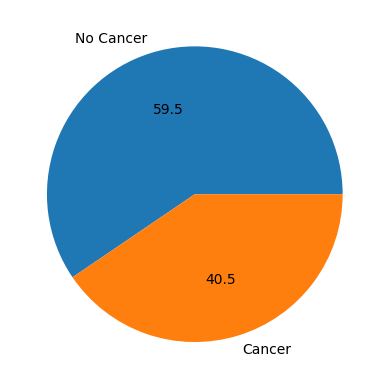

<Figure size 2000x2000 with 0 Axes>

In [46]:
labels_count = train_labels_df.label.value_counts()
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], autopct='%1.1f')
plt.figure(figsize=(20,20))
plt.show()

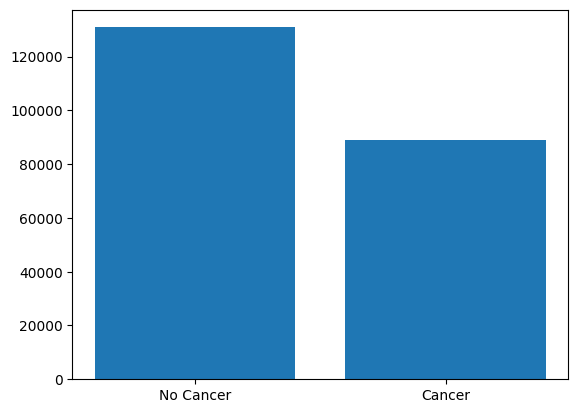

<Figure size 2000x2000 with 0 Axes>

In [47]:
labels_count = train_labels_df.label.value_counts()
plt.bar(x=["No Cancer", "Cancer"], height=labels_count)
plt.figure(figsize=(20,20))
plt.show()

I will be relying on the label stating the image has metastases cancer instead of looking at the images myself. Let's add the filepath of each image to the corresponding id for ease.

In [48]:
train_path = 'train/'
# Add image paths to the data frame for ease.
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0])
df_data = df.merge(train_labels_df, on = "id")

There's simply too many images for the kernel's memory so I purposely used a smaller size instead of the full training data.

In [49]:
# There's way too many images and kernel kept running out of memory so I took a
# smaller sample size of 5k per label type, so 10k in total.
SAMPLE_SIZE = 5000

df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 123)
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 123)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))
print(df_data.head())
print(df_data.info())


                                                   path  \
9458  train\58e29f9959ea3985465a022dbf02ea1ba8b3df3e...   
9496  train\97c445e2ad8897ceed0255702987e601926ed44c...   
7193  train\b5a3d77b2148860452ea397d61ccd918adae180e...   
4145  train\b3c46560751f1fa81caf7f692dbda3a4ff761262...   
3942  train\4ba925defda39e4927db6831dc73ca2aff1e33ba...   

                                            id  label  
9458  58e29f9959ea3985465a022dbf02ea1ba8b3df3e      1  
9496  97c445e2ad8897ceed0255702987e601926ed44c      1  
7193  b5a3d77b2148860452ea397d61ccd918adae180e      1  
4145  b3c46560751f1fa81caf7f692dbda3a4ff761262      0  
3942  4ba925defda39e4927db6831dc73ca2aff1e33ba      0  
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 9458 to 4454
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    10000 non-null  object
 1   id      10000 non-null  object
 2   label   10000 non-null  int64 
dtypes: int64(1), object

Using imread to change the image to a numeric array.

In [51]:
df_data['image'] = df_data['path'].map(imread)
df_data.sample(3)

,path,id,label,image
3307,train\e668f31706d697db8a1c6739ab80f44b488594c2...,e668f31706d697db8a1c6739ab80f44b488594c2,0,"[[[255, 246, 255], [218, 205, 222], [191, 179,..."
2873,train\3913051475bdb0e7af0d1e8388ff64a6ddf5cbeb...,3913051475bdb0e7af0d1e8388ff64a6ddf5cbeb,0,"[[[71, 39, 89], [74, 44, 80], [84, 60, 74], [2..."
558,train\b69f83ca87ca5c920f80418253fd721618da951c...,b69f83ca87ca5c920f80418253fd721618da951c,0,"[[[218, 177, 191], [216, 175, 189], [227, 186,..."


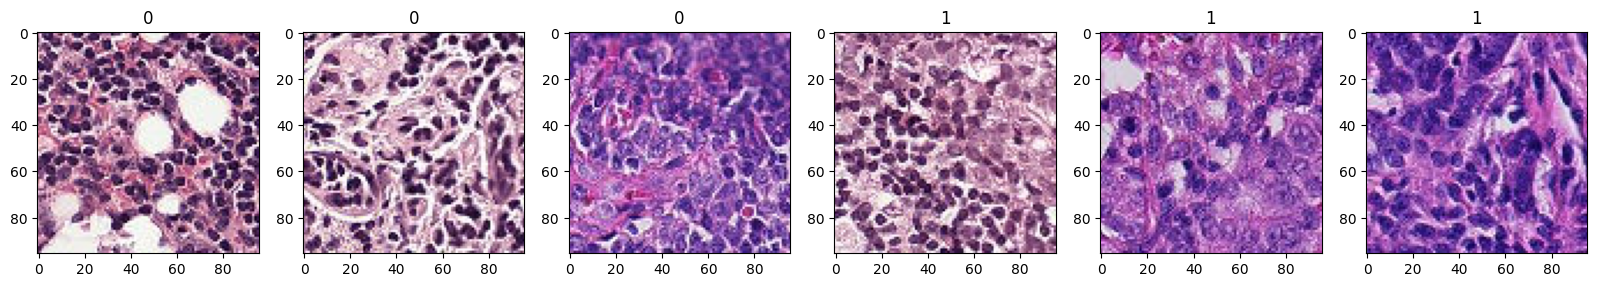

In [53]:
images = [(df_data['image'][0], df_data['label'][0]),
          (df_data['image'][1], df_data['label'][1]),
          (df_data['image'][2], df_data['label'][2]),
          (df_data['image'][7500], df_data['label'][7500]),
          (df_data['image'][7501], df_data['label'][7501]),
          (df_data['image'][7502], df_data['label'][7502])]

fig, m_axs = plt.subplots(1, len(images), figsize = (20, 20))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(images[ii][0])
    c_ax.set_title(images[ii][1])

In [ ]:
# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=123, stratify=y)

,label
id,
43cae5227b25b8712bc020a998053144e07e847d,0
603d04959d5128695c7627872721298a46cc450b,0
66a7283d7e039cc7680d40dadc7577ff79932007,0
b345879b5a4c616edddb6d194ca2eaffd8fbb825,1
308c6ef300b1aeaa0e5821cde4b049a2bf0a8088,1
